# `EmissionAbsorptionModel` Tutorial

Trey V. Wenger (c) August 2024

Here we demonstrate the basic features of the `EmissionAbsorptionModel` model. `EmissionAbsorptionModel` models both 21cm emission and absorption observations simultaneously.

In [1]:
# General imports    
import os
import pickle
import time

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

print("pymc version:", pm.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import caribou_hi
print("caribou_hi version:", caribou_hi.__version__)

# Notebook configuration
pd.options.display.max_rows = None

pymc version: 5.16.2
bayes_spec version: 1.6.3+4.ga230ddc.dirty
caribou_hi version: 1.0.0-staging+1.g238726f.dirty


## Simulating Data

To test the model, we must simulate some data. We can do this with `EmissionAbsorptionModel`, but we must pack a "dummy" data structure first. The model expects the observations to be named `"emission"` and `"absorption"`.

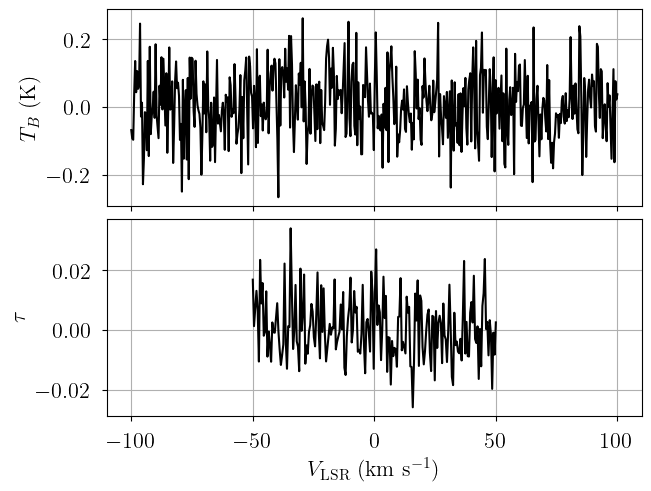

In [2]:
from bayes_spec import SpecData

# spectral axes definitions
emission_axis = np.linspace(-100.0, 100.0, 500) # km s-1
absorption_axis = np.linspace(-50.0, 50.0, 200) # km s-1

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
rms_emission = 0.1 # K
rms_absorption = 0.01 # optical depth

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
emission = rms_emission * np.random.randn(len(emission_axis))
absorption = rms_absorption * np.random.randn(len(absorption_axis))

dummy_data = {
    "emission": SpecData(
        emission_axis,
        emission,
        rms_emission,
        xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
        ylabel=r"$T_B$ (K)"),
    "absorption": SpecData(
        absorption_axis,
        absorption,
        rms_absorption,
        xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
        ylabel=r"$\tau$"),
}

# Plot dummy data
fig, axes = plt.subplots(2, layout="constrained", sharex=True)
axes[0].plot(dummy_data["emission"].spectral, dummy_data["emission"].brightness, "k-")
axes[1].plot(dummy_data["absorption"].spectral, dummy_data["absorption"].brightness, "k-")
axes[1].set_xlabel(dummy_data["emission"].xlabel)
axes[0].set_ylabel(dummy_data["emission"].ylabel)
_ = axes[1].set_ylabel(dummy_data["absorption"].ylabel)

Now that we have a dummy data format, we can generate a simulated observation by evaluating the likelihood.

In [3]:
from caribou_hi import EmissionAbsorptionModel

# Initialize and define the model
n_clouds = 3
baseline_degree = 2
model = EmissionAbsorptionModel(
    dummy_data,
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    bg_temp = 3.77, # assumed background temperature (K)
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_NHI = [20.0, 0.5], # mean and width of log10(NHI) prior (cm-2)
    prior_log10_nHI = [1.0, 0.5], # mean and width of log10(nHI) prior (cm-3)
    prior_log10_tkin = [2.0, 0.5], # mean and width of log10(kinetic temp) prior (K)
    prior_log10_n_alpha = [-6.0, 0.5], # mean and width of log10(n_alpha) prior (cm-3)
    prior_log10_larson_linewidth = [0.2, 0.05], # mean and width of log10(larson_linewidth) prior (km s-1)
    prior_larson_power = [0.4, 0.05], # mean and width of larson_power prior
    prior_velocity = [0.0, 2.0], # mean and width of velocity prior (km/s)
    prior_rms_emission = 0.1, # width of emission rms (K) prior
    prior_rms_absorption = 0.1, # width of emission rms (K) prior
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

In [4]:
# Evaluate likelihood for given model parameters
sim_params = {
    "log10_NHI": np.array([20.0, 21.0, 20.5]),
    "log10_nHI": np.array([2.0, 0.0, 0.5]),
    "log10_tkin": np.array([2.5, 4.0, 3.5]),
    "log10_n_alpha": np.array([-6.0, -5.0, -6.0]),
    "log10_larson_linewidth": np.array([0.15, 0.2, 0.25]),
    "larson_power": np.array([0.5, 0.3, 0.3]),
    "velocity": np.array([0.0, -5.0, 5.0]),
}

sim_params_emission = sim_params.copy()
sim_params_emission["rms_emission"] = rms_emission
sim_params_emission["baseline_emission_norm"] = np.array([-1.0, 2.0, 5.0])

sim_params_absorption = sim_params.copy()
sim_params_absorption["rms_absorption"] = rms_absorption
sim_params_absorption["baseline_absorption_norm"] = np.array([2.0, -2.0, 2.0])

emission = model.model["emission"].eval(sim_params_emission)
absorption = model.model["absorption"].eval(sim_params_absorption)

data = {
    "emission": SpecData(
        emission_axis,
        emission,
        rms_emission,
        xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
        ylabel=r"$T_B$ (K)"),
    "absorption": SpecData(
        absorption_axis,
        absorption,
        rms_absorption,
        xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
        ylabel=r"$\tau$"),
}

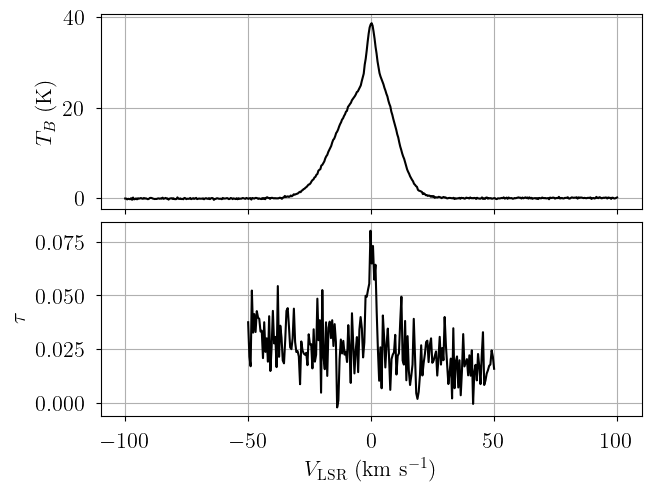

In [5]:
# Plot data
fig, axes = plt.subplots(2, layout="constrained", sharex=True)
axes[0].plot(data["emission"].spectral, data["emission"].brightness, "k-")
axes[1].plot(data["absorption"].spectral, data["absorption"].brightness, "k-")
axes[1].set_xlabel(data["emission"].xlabel)
axes[0].set_ylabel(data["emission"].ylabel)
_ = axes[1].set_ylabel(data["absorption"].ylabel)

## Model Definition

Finally, with our model definition and (simulated) data in hand, we can explore the capabilities of `TauModel`. Here we create a new model with the simulated data.

In [6]:
# Initialize and define the model
model = EmissionAbsorptionModel(
    data,
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    bg_temp = 3.77, # assumed background temperature (K)
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_NHI = [20.0, 0.5], # mean and width of log10(NHI) prior (cm-2)
    prior_log10_nHI = [1.0, 0.5], # mean and width of log10(nHI) prior (cm-3)
    prior_log10_tkin = [2.0, 0.5], # mean and width of log10(kinetic temp) prior (K)
    prior_log10_n_alpha = [-6.0, 0.5], # mean and width of log10(n_alpha) prior (cm-3)
    prior_log10_larson_linewidth = [0.2, 0.05], # mean and width of log10(larson_linewidth) prior (km s-1)
    prior_larson_power = [0.4, 0.05], # mean and width of larson_power prior
    prior_velocity = [0.0, 2.0], # mean and width of velocity prior (km/s)
    prior_rms_emission = 0.1, # width of emission rms (K) prior
    prior_rms_absorption = 0.1, # width of emission rms (K) prior
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

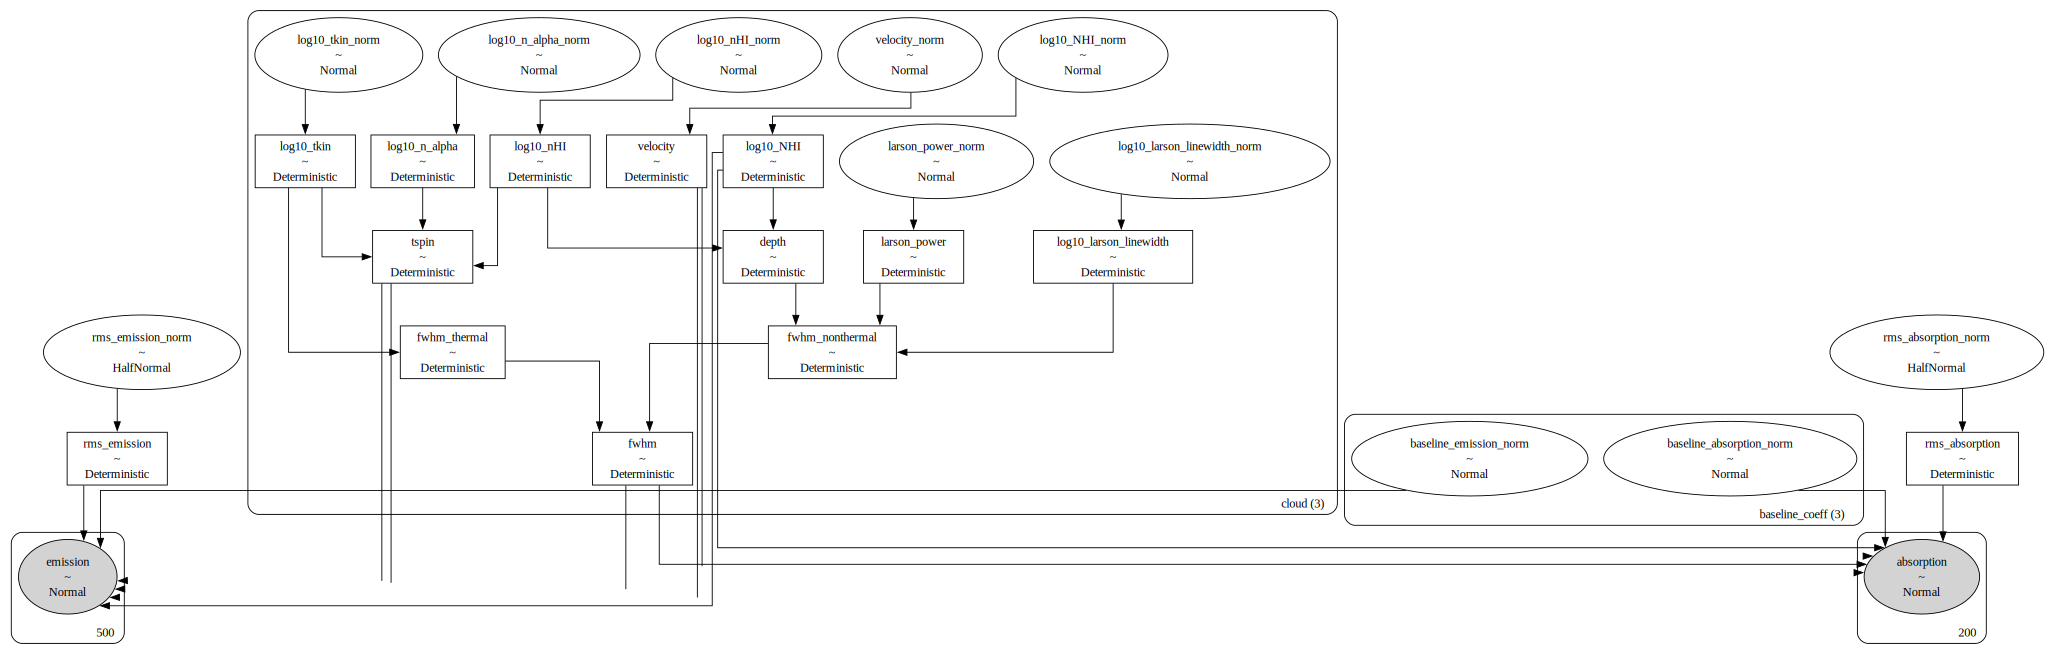

In [7]:
# Plot model graph
model.graph().render('emission_absorption_model', format='png')
model.graph()

In [8]:
# model string representation
print(model.model.str_repr())

     baseline_emission_norm ~ Normal(0, <constant>)
   baseline_absorption_norm ~ Normal(0, <constant>)
             log10_NHI_norm ~ Normal(0, 1)
             log10_nHI_norm ~ Normal(0, 1)
            log10_tkin_norm ~ Normal(0, 1)
         log10_n_alpha_norm ~ Normal(0, 1)
log10_larson_linewidth_norm ~ Normal(0, 1)
          larson_power_norm ~ Normal(0, 1)
              velocity_norm ~ Normal(0, 1)
          rms_emission_norm ~ HalfNormal(0, 1)
        rms_absorption_norm ~ HalfNormal(0, 1)
                  log10_NHI ~ Deterministic(f(log10_NHI_norm))
                  log10_nHI ~ Deterministic(f(log10_nHI_norm))
                 log10_tkin ~ Deterministic(f(log10_tkin_norm))
              log10_n_alpha ~ Deterministic(f(log10_n_alpha_norm))
     log10_larson_linewidth ~ Deterministic(f(log10_larson_linewidth_norm))
               larson_power ~ Deterministic(f(larson_power_norm))
                   velocity ~ Deterministic(f(velocity_norm))
                      tspin ~ Determinis

We check that our prior distributions are reasonable by drawing prior predictive checks. Each colored line is a simulated "observation" with parameters drawn from the prior distributions. You should check that these simulated observations at least somewhat overlap your actual observation (black line).

Sampling: [absorption, baseline_absorption_norm, baseline_emission_norm, emission, larson_power_norm, log10_NHI_norm, log10_larson_linewidth_norm, log10_nHI_norm, log10_n_alpha_norm, log10_tkin_norm, rms_absorption_norm, rms_emission_norm, velocity_norm]


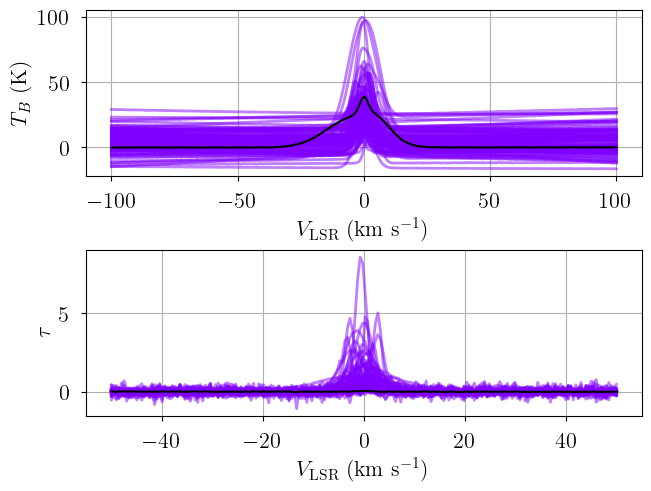

In [9]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive)

## Variational Inference

We can approximate the posterior distribution using variational inference.

In [10]:
start = time.time()
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.01, # VI relative convergence threshold
    abs_tolerance = 0.1, # VI absolute convergence threshold
    learning_rate = 1e-2, # VI learning rate
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

Convergence achieved at 3700
Interrupted at 3,699 [3%]: Average Loss = 2.5737e+05


Runtime: 0.67 minutes


In [11]:
pm.summary(model.trace.posterior)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
baseline_absorption_norm[0],-0.362,0.068,-0.498,-0.245,0.002,0.002,898.0,825.0,NaN
baseline_absorption_norm[1],-1.112,0.214,-1.491,-0.689,0.007,0.006,788.0,927.0,NaN
baseline_absorption_norm[2],1.269,0.865,-0.295,2.904,0.030,0.021,864.0,872.0,NaN
baseline_emission_norm[0],-0.487,0.005,-0.497,-0.477,0.000,0.000,1002.0,825.0,NaN
baseline_emission_norm[1],0.013,0.015,-0.015,0.040,0.001,0.000,836.0,874.0,NaN
baseline_emission_norm[2],0.368,0.090,0.195,0.537,0.003,0.002,920.0,850.0,NaN
depth[0],103.019,6.218,91.466,114.559,0.204,0.144,926.0,944.0,NaN
depth[1],114.883,6.437,102.755,127.091,0.206,0.146,975.0,982.0,NaN
depth[2],11.140,1.269,8.852,13.429,0.040,0.028,1004.0,952.0,NaN
fwhm[0],26.196,1.041,24.402,28.194,0.034,0.024,926.0,874.0,NaN


Sampling: [absorption, emission]


Output()

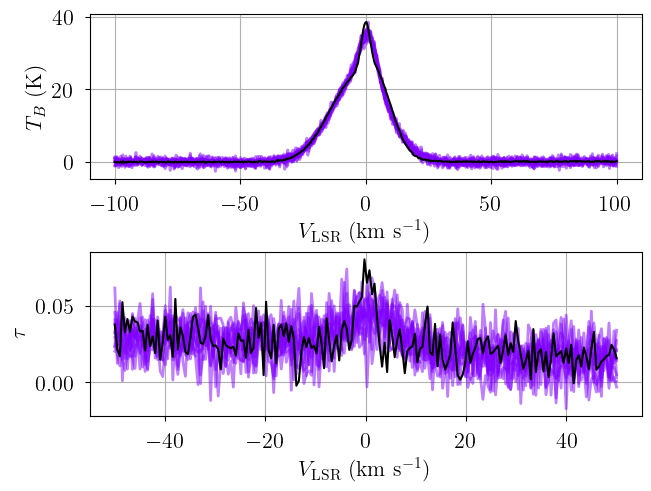

In [12]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

## Posterior Sampling: MCMC

We can sample from the posterior distribution using MCMC.

In [13]:
start = time.time()
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 4, # number of independent chains
    cores = 4, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.01, "abs_tolerance": 0.1, "learning_rate": 1e-2}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.8}, # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 3700
Interrupted at 3,699 [3%]: Average Loss = 2.5737e+05
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_emission_norm, baseline_absorption_norm, log10_NHI_norm, log10_nHI_norm, log10_tkin_norm, log10_n_alpha_norm, log10_larson_linewidth_norm, larson_power_norm, velocity_norm, rms_emission_norm, rms_absorption_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 579 seconds.


There were 572 divergences in converged chains.
Runtime: 10.43 minutes


In [16]:
model.solve(p_threshold=0.9)

GMM converged to unique solution


Check that the effective sample sizes are large and the covergence statistic `r_hat` is close to 1! If not, you may have to increase the number of tuning steps (`tune=2000`) or the NUTS acceptance rate (`target_accept=0.9`).

In [17]:
print("solutions:", model.solutions)
az.summary(model.trace["solution_0"])
# this also works: az.summary(model.trace.solution_0)

solutions: [0]


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
baseline_absorption_norm[0],-0.216,0.069,-0.347,-0.087,0.002,0.002,1041.0,991.0,1.01
baseline_absorption_norm[1],-1.575,0.168,-1.887,-1.243,0.004,0.003,2049.0,1358.0,1.00
baseline_absorption_norm[2],-0.301,0.858,-1.856,1.392,0.021,0.015,1610.0,1560.0,1.00
baseline_emission_norm[0],-0.459,0.001,-0.462,-0.457,0.000,0.000,1499.0,2334.0,1.00
baseline_emission_norm[1],0.025,0.002,0.021,0.028,0.000,0.000,2687.0,2166.0,1.00
baseline_emission_norm[2],0.057,0.023,0.016,0.102,0.001,0.000,1469.0,2117.0,1.00
depth[0],27.661,27.517,0.649,72.106,0.723,0.511,1213.0,1641.0,1.01
depth[1],96.390,94.694,0.780,247.770,4.898,3.466,117.0,1000.0,1.04
depth[2],0.895,1.141,0.045,2.430,0.028,0.020,1536.0,1791.0,1.00
fwhm[0],14.062,0.166,13.760,14.385,0.006,0.004,894.0,1366.0,1.00


We generate posterior predictive checks as well as a trace plot of the individual chains. In the posterior predictive plot, we show each chain as a different color. Each line is one posterior sample.

Sampling: [absorption, emission]


Output()

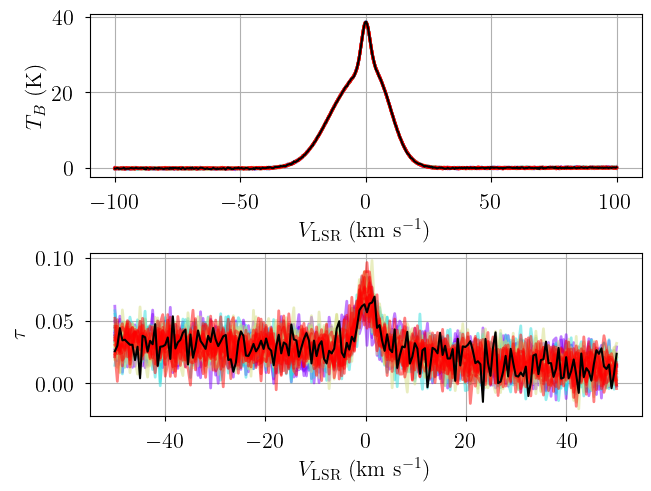

In [18]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

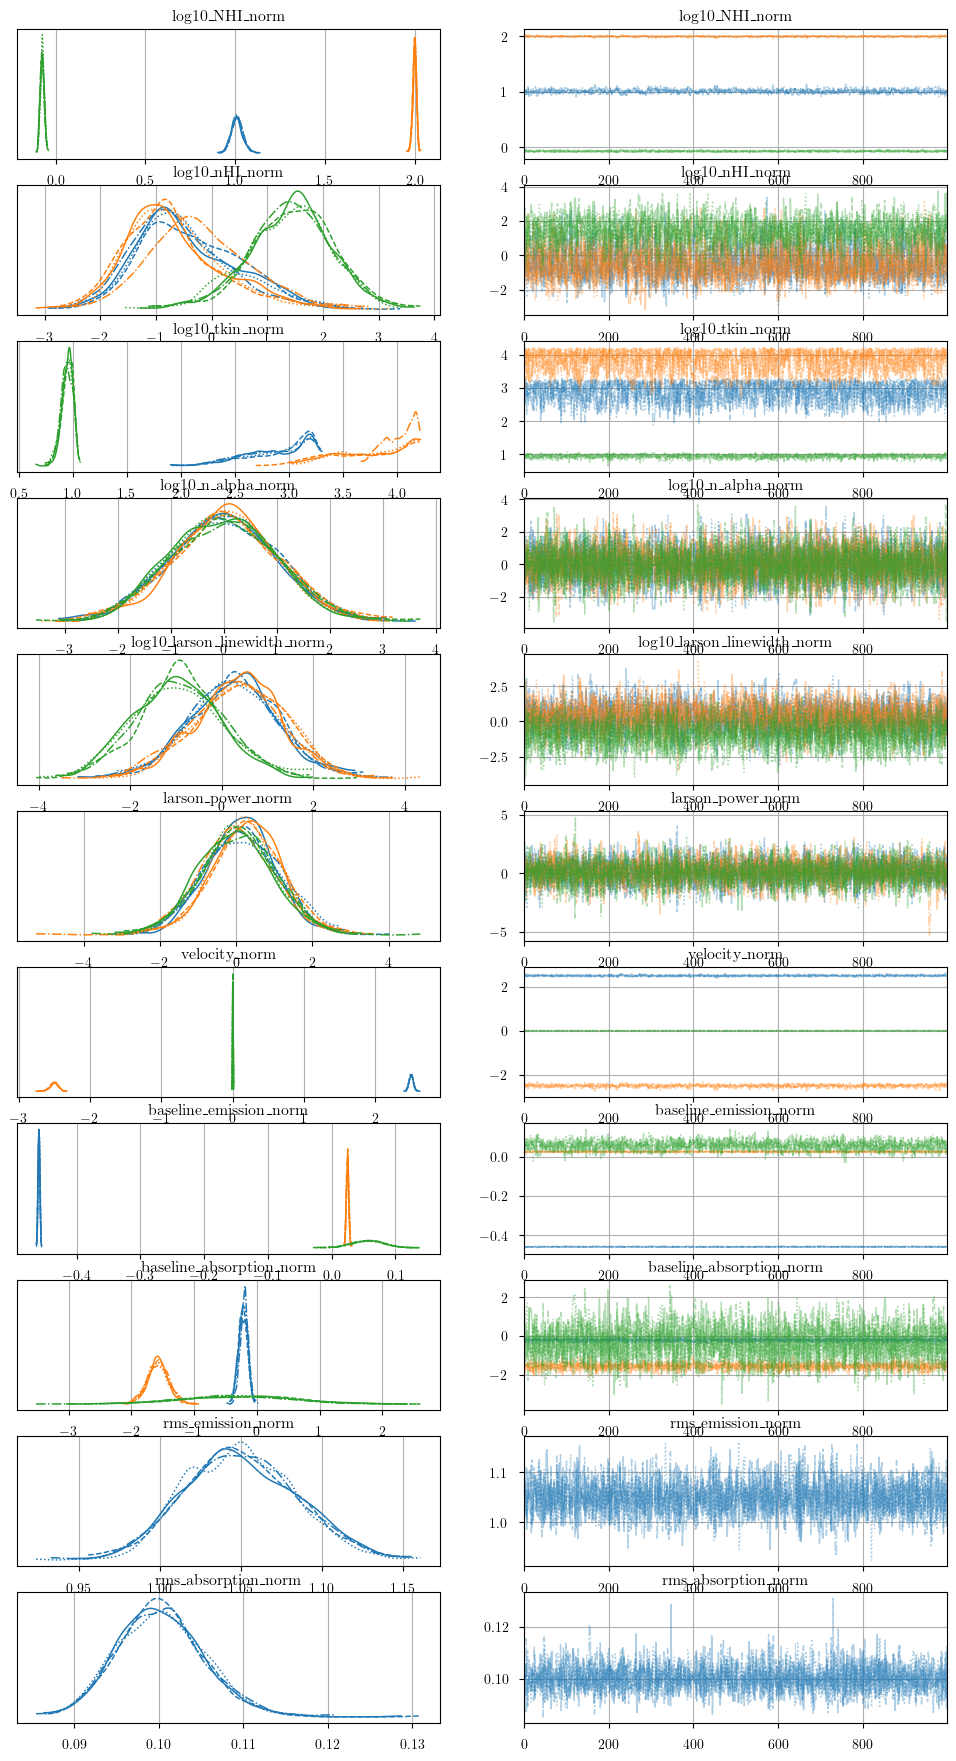

In [19]:
from bayes_spec.plots import plot_traces

_ = plot_traces(model.trace.solution_0, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)

We can inspect the posterior distribution pair plots. First, the normalized, free cloud parameters.

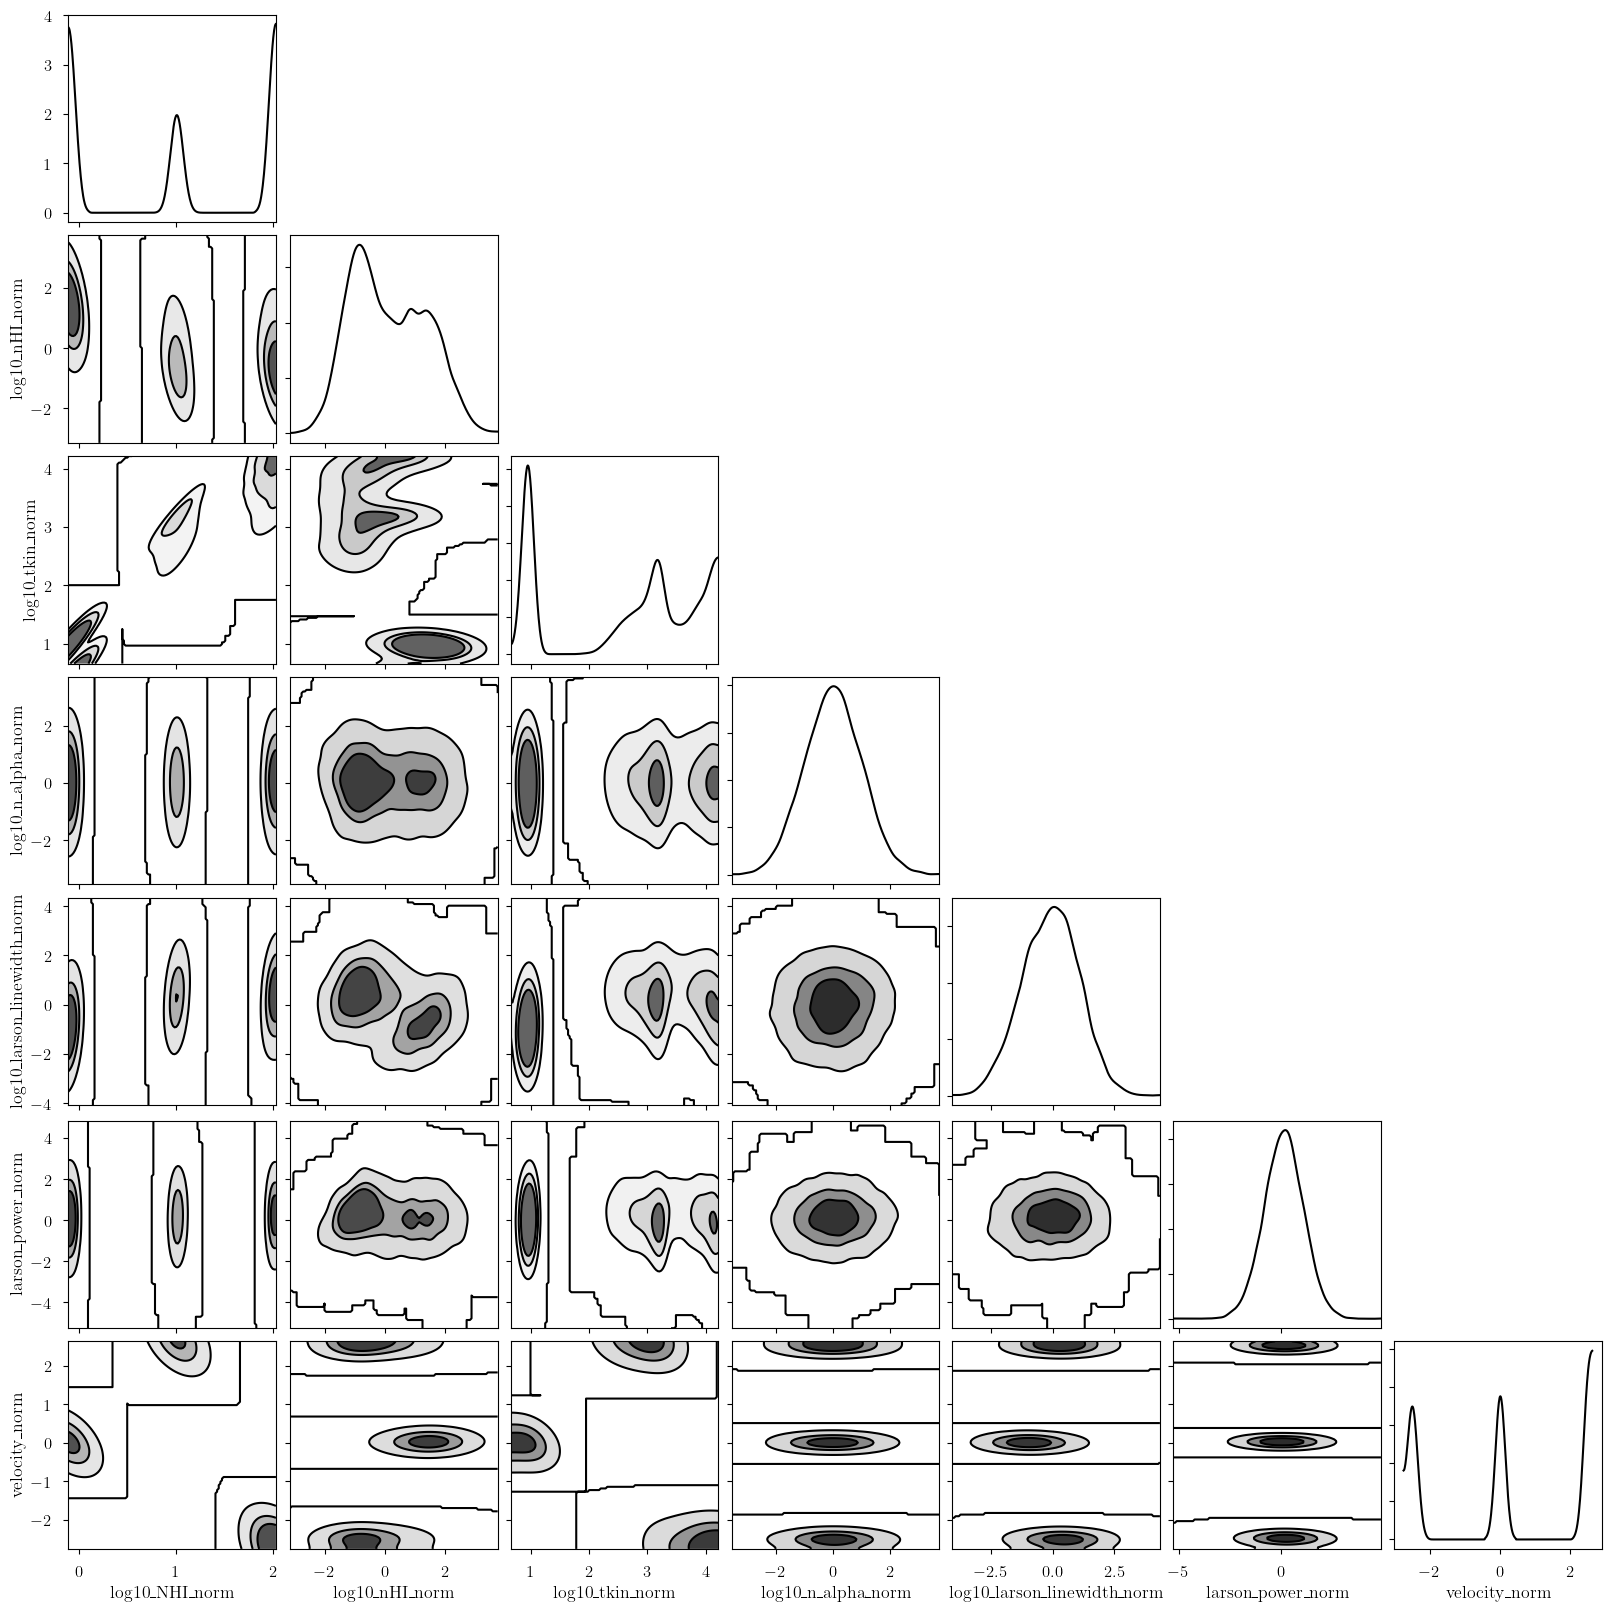

In [20]:
from bayes_spec.plots import plot_pair

_ = plot_pair(
    model.trace.solution_0, # samples
    model.cloud_freeRVs, # var_names to plot
    labeller=model.labeller, # label manager
)

Notice that there are three posterior modes. These correspond to the three clouds of the model. We can plot the posterior distributions of the deterministic quantities for a single cloud. Also notice the tight correlation between column density and excitation temperature: optical depth spectra alone struggle to break this degeneracy!

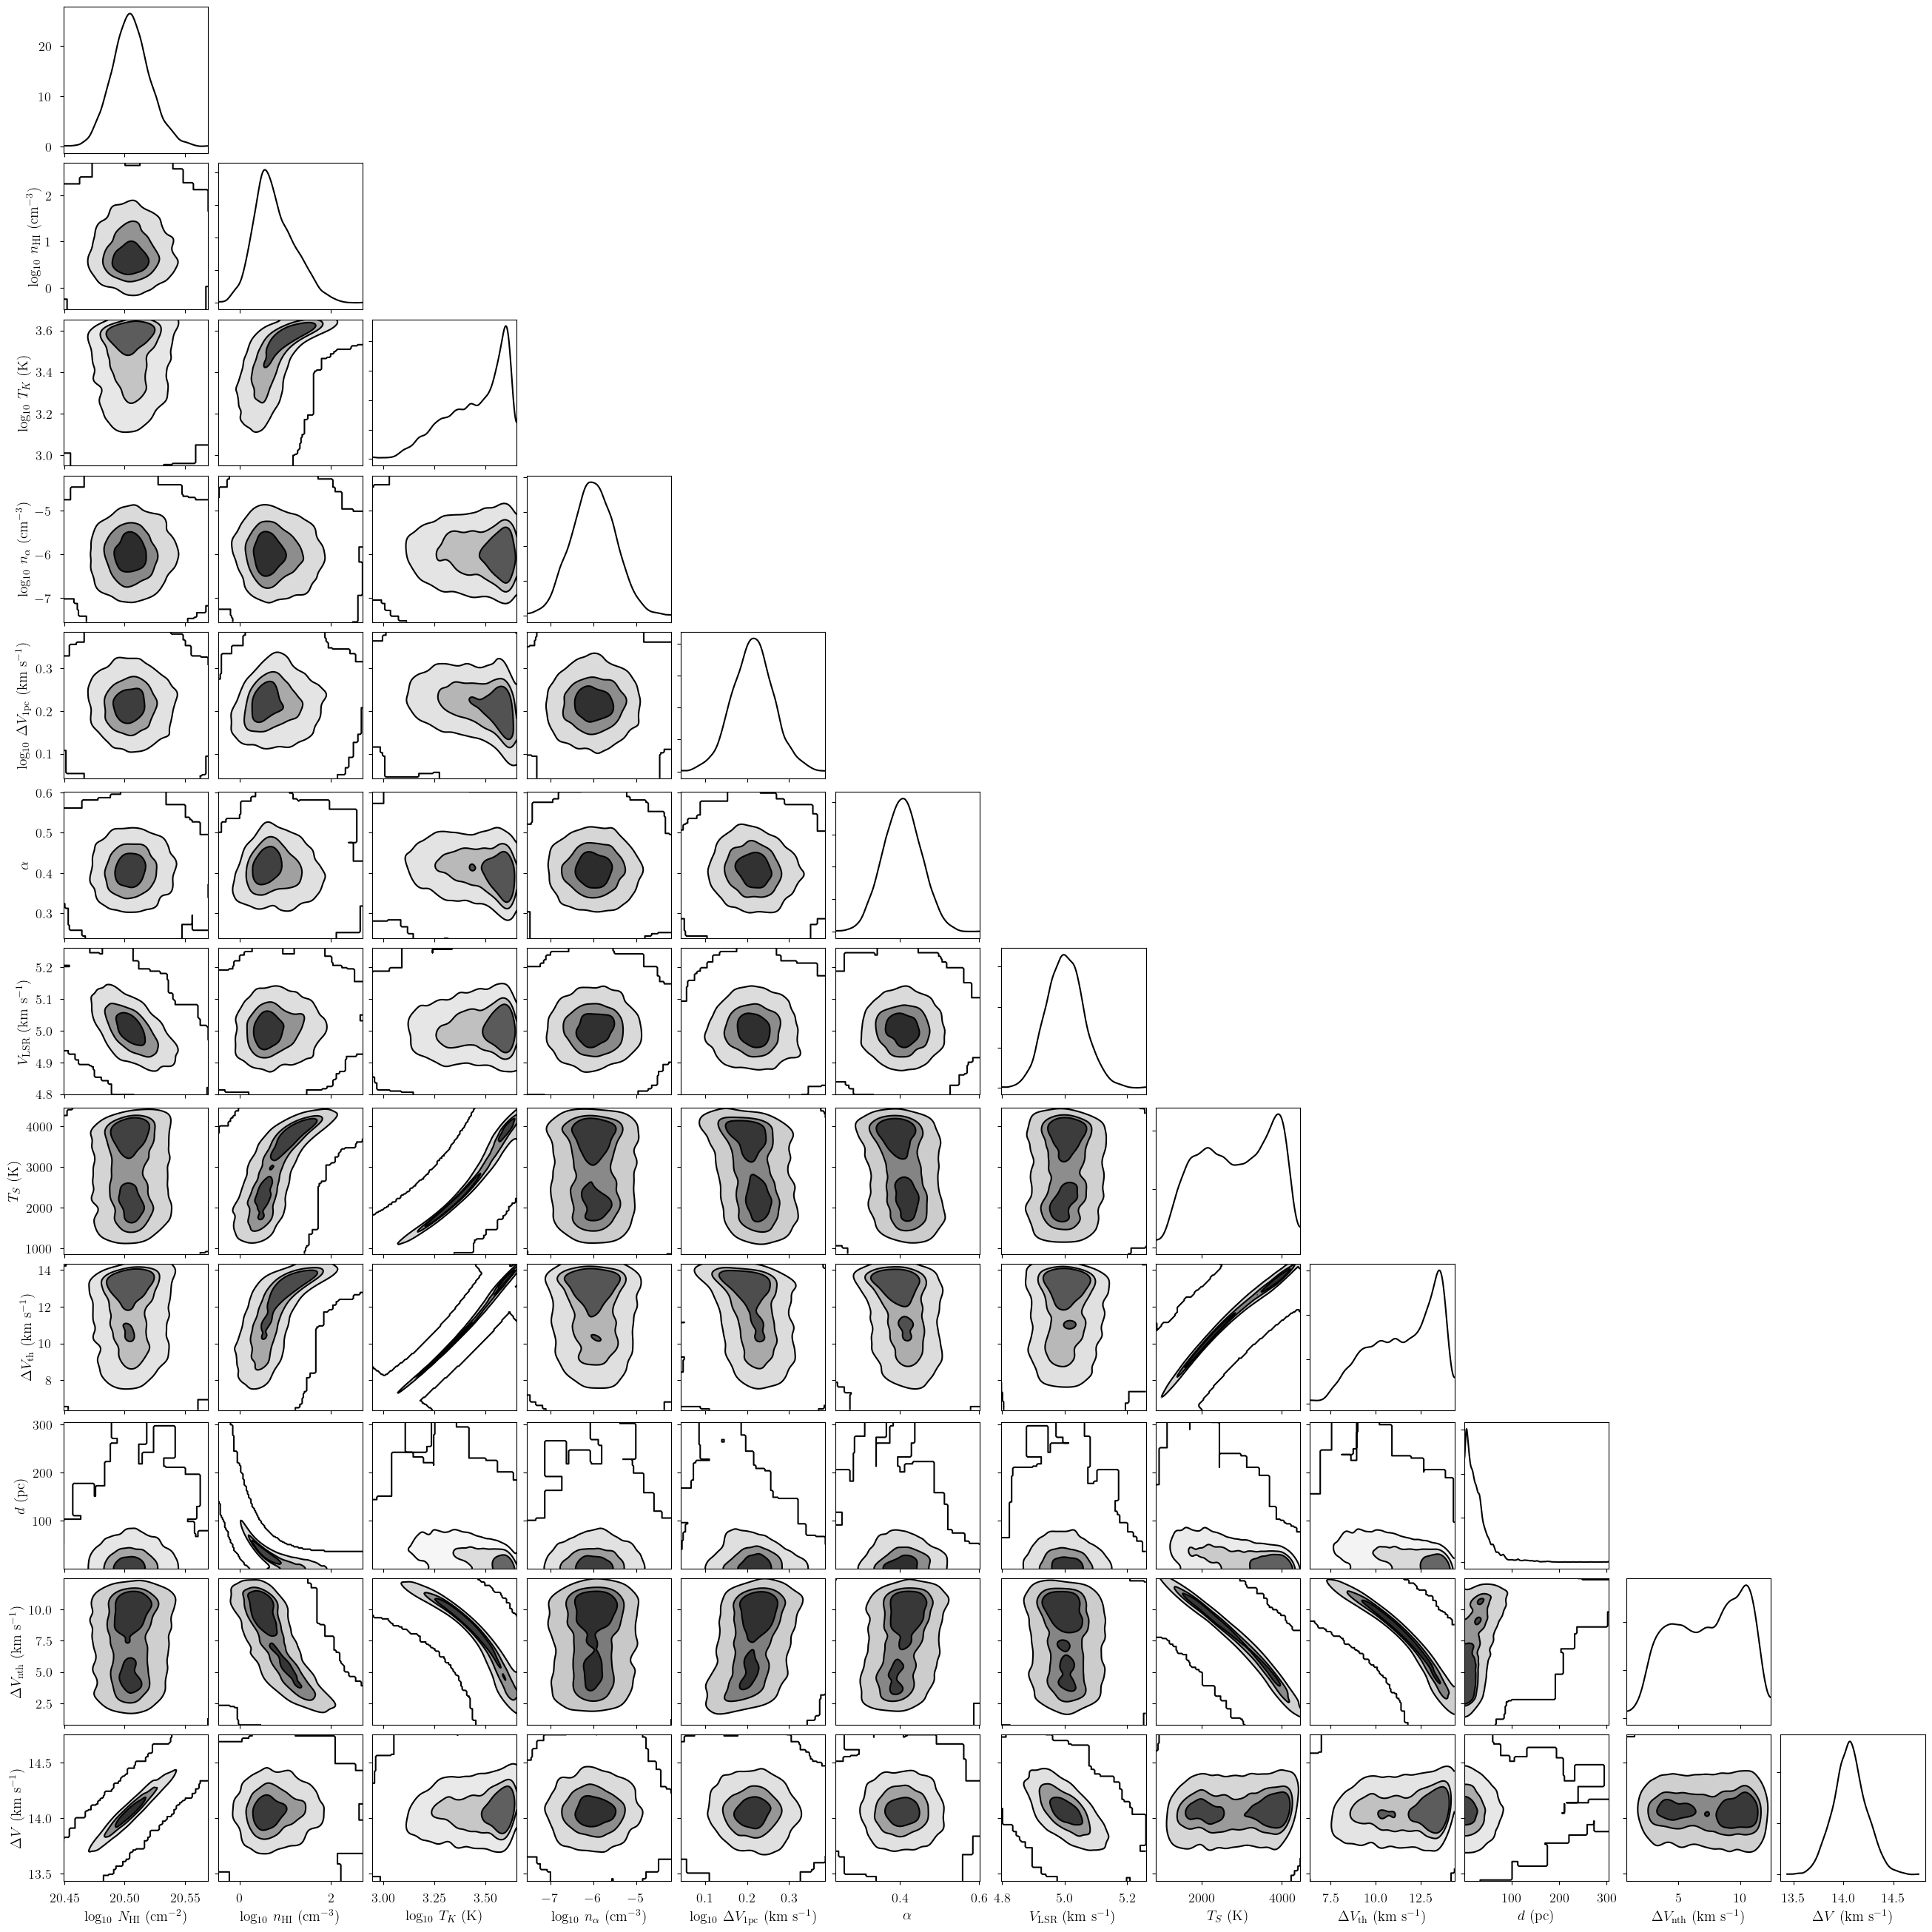

In [21]:
_ = plot_pair(
    model.trace.solution_0.sel(cloud=0), # samples
    model.cloud_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
)

Finally, we can get the posterior statistics, Bayesian Information Criterion (BIC), etc.

In [22]:
point_stats = az.summary(model.trace.solution_0, kind='stats', hdi_prob=0.68)
print("BIC:", model.bic())
display(point_stats)

BIC: 4954.802741853127


,mean,sd,hdi_16%,hdi_84%
baseline_absorption_norm[0],-0.216,0.069,-0.276,-0.139
baseline_absorption_norm[1],-1.575,0.168,-1.744,-1.422
baseline_absorption_norm[2],-0.301,0.858,-1.094,0.596
baseline_emission_norm[0],-0.459,0.001,-0.461,-0.458
baseline_emission_norm[1],0.025,0.002,0.023,0.027
baseline_emission_norm[2],0.057,0.023,0.034,0.081
depth[0],27.661,27.517,0.821,31.522
depth[1],96.390,94.694,2.143,108.958
depth[2],0.895,1.141,0.105,0.900
fwhm[0],14.062,0.166,13.885,14.210


Including both the emission and absorption data places more robust constraints on the spin temperature.